

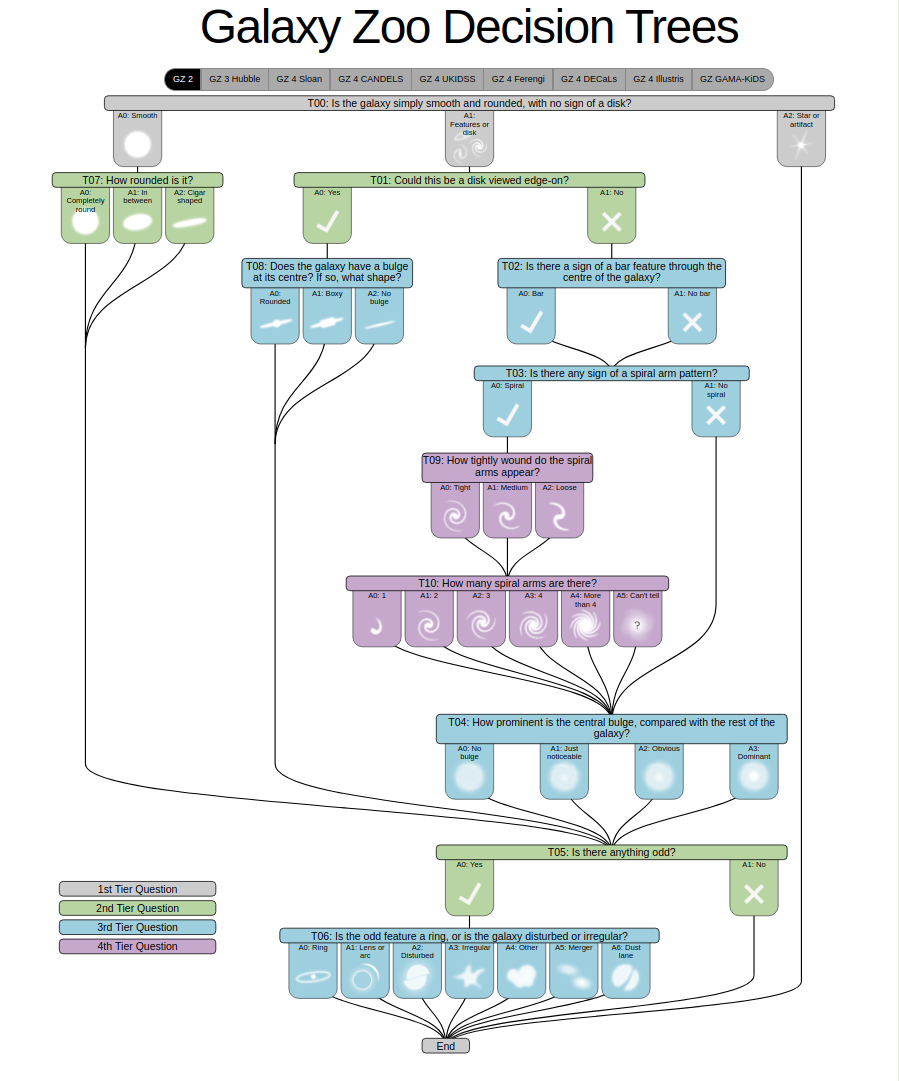






In [58]:
import warnings
warnings.filterwarnings("ignore")

In [59]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D
from keras import backend as K
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

In [60]:
def get_image_class(x, x1,y1, shape, crop_size):
    x = np.array(x)
    #x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    return x   

def get_image(path, x1,y1, shape, crop_size):
    x = plt.imread(path)
    #x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    return x    

In [61]:
ORIG_SHAPE = (500,400)
CROP_SIZE = (128,128)
IMG_SHAPE = (64,64)
batch_size = 128
df = pd.read_csv('training_solutions_rev1.csv')

def test_image_generator(ids, file, shape=IMG_SHAPE):

    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
    x_batch = []
    for i in ids:
        x = get_image(file+'/'+i, x1, y1, shape=IMG_SHAPE, crop_size=CROP_SIZE)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch


In [62]:
def pred_csv(model,file):
    val_files = os.listdir(file)
    val_predictions = []
    N_val = len(val_files)
    for i in tqdm(np.arange(0, N_val, batch_size)):
        if i+batch_size > N_val:
            upper = N_val
        else:
            upper = i+batch_size
        X = test_image_generator(val_files[i:upper],file)
        y_pred = model.predict(X)
        val_predictions.append(y_pred)
    val_predictions = np.array(val_predictions)
    Y_pred = np.vstack(val_predictions)
    ids = np.array([v.split('.')[0] for v in val_files]).reshape(len(val_files),1)
    submission_df = pd.DataFrame(np.hstack((ids, Y_pred)), columns=df.columns)
    submission_df = submission_df.sort_values(by=['GalaxyID'])
    submission_df.to_csv('test1.csv', index=False)


In [63]:
def pred_class(model,file):
    pred = []
    for f in os.listdir(file):
        img = Image.open(file+'/'+f)
        #Reduce dimensions from 256,256 to 64,64
        x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
        y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
        x_t = []
        x_t.append(get_image_class(img,x1,y1,IMG_SHAPE,CROP_SIZE))
        ypred = model.predict(np.array(x_t))
        ypred = np.round(ypred)
        pred.append(ypred)
    return pred

In [64]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model1 = Sequential()
model1.add(Conv2D(512, (3, 3), input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))
model1.add(Conv2D(256, (3, 3)))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(256, (3, 3)))
model1.add(Conv2D(128, (3, 3)))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3)))
model1.add(Conv2D(128, (3, 3)))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(GlobalMaxPooling2D())


model1.add(Dropout(0.25))
model1.add(Dense(128))
model1.add(Activation('relu'))
model1.add(Dropout(0.25))
model1.add(Dense(128))
model1.add(Activation('relu'))
model1.add(Dropout(0.25))
model1.add(Dense(128))
model1.add(Activation('relu'))
model1.add(Dropout(0.25))
model1.add(Dense(10))
model1.add(Activation('sigmoid'))

#2nd Model
model = Sequential()
model.add(Conv2D(512, (3, 3), input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))
model.add(Conv2D(256, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Conv2D(128, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Conv2D(128, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(GlobalMaxPooling2D())


model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(37))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=[root_mean_squared_error])
model.load_weights("30epoch_final_weights_test1.h5")
model1.compile(loss='binary_crossentropy', optimizer='adamax', metrics=[root_mean_squared_error])
model1.load_weights("model_weights_12000.h5")

In [65]:
def predict(filename):
    pred_csv(model,filename)
    pred = pred_class(model1,filename)

    i=1

    for p in pred:
        print("Predictions for {f}.jpg : ".format(f=i),end="")
        print(p)

        i=i+1
        if p[0][0] == 1:
            answer.append("Disturbed Galaxies")
        elif p[0][1] == 1:
            answer.append("Merging Galaxies")

        elif p[0][2] == 1:
            answer.append("Round Smooth Galaxies")

        elif p[0][3] == 1:
            answer.append("In-between Round Smooth Galaxies")

        elif p[0][4] == 1:
            answer.append("Cigar Shaped Smooth  Galaxies")

        elif p[0][5] == 1:
            answer.append("Barred Spiral Galaxies")

        elif p[0][6] == 1:
            answer.append("Unbarred Tight Spiral Galaxies")

        elif p[0][7] == 1:
            answer.append("Unbarred Loose Spiral Galaxies")

        elif p[0][8] == 1:
            answer.append("Edge-on Galaxies without Bulge")
  
        elif p[0][9] == 1:
            answer.append("Edge-on Galaxies with Bulge")
  
        else :
            answer.append("Irregular Galaxy")


In [66]:
answer=[]
predict('Final_inputs')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Predictions for 1.jpg : [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


# Summary report Genertaor

In [67]:
import pandas as pd
df = pd.read_csv('test1.csv')
df = df.drop('GalaxyID',axis=1)

In [68]:
def return_result(path_obtained):
    print("The obtained classes are : ",path_obtained)
    print()
    if 'Class1.1' in path_obtained:
        print("It is a smooth Galaxy")
    if 'Class1.2' in path_obtained:
        print("It has features and disk")
    if 'Class1.3' in path_obtained:
        print("It is a star/artifact")

    if 'Class2.1' in path_obtained:
        print("It is a disk viewed edge on")
    if 'Class2.2' in path_obtained:
        print("It is a disk viewed edge on")

    if 'Class3.1' in path_obtained:
        print("There is a bar feature at the center of galaxy")
    if 'Class3.2' in path_obtained:
        print("There is NO bar feature at the center of galaxy")

    if 'Class4.1' in path_obtained:
        print("There is a sign of spiral arm pattern")
    if 'Class4.2' in path_obtained:
        print("There is NO sign of spiral arm pattern")

    if 'Class5.1' in path_obtained:
        print("There is no Buldge in the center")
    if 'Class5.2' in path_obtained:
        print("There is a just noticible Buldge in the center")
    if 'Class5.3' in path_obtained:
        print("There is a obvious Buldge in the center")
    if 'Class5.4' in path_obtained:
        print("There is dominant Buldge in the center")

    if 'Class6.1' in path_obtained:
        print("There is something odd")
    if 'Class6.2' in path_obtained:
        print("There is nothing odd")


    if 'Class7.1' in path_obtained:
        print("It is completely round")
    if 'Class7.2' in path_obtained:
        print("It is inbetween round")
    if 'Class7.3' in path_obtained:
        print("It is cigar shaped")

    if 'Class8.1' in path_obtained:
        print("There is a ring")
    if 'Class8.2' in path_obtained:
        print("There is a lens or arc")
    if 'Class8.3' in path_obtained:
        print("It is distributed")
    if 'Class8.4' in path_obtained:
        print("It is irregular")
    if 'Class8.5' in path_obtained:
        print("Cant Find")
    if 'Class8.6' in path_obtained:
        print("It is a Merger Galaxy")
    if 'Class8.7' in path_obtained:
        print("There is a Dust Lane")

    if 'Class9.1' in path_obtained:
        print("It is rounded at the center")
    if 'Class9.2' in path_obtained:
        print("It is BOXY at the center")
    if 'Class9.3' in path_obtained:
        print("It has no buldge at the center")

    if 'Class10.1' in path_obtained:
        print("It has tight spiral arms")
    if 'Class10.2' in path_obtained:
        print("It has medium tight spiral arms")
    if 'Class10.3' in path_obtained:
        print("It has loose spiral arms")

    if 'Class11.1' in path_obtained:
        print("There is 1 spiral arm")
    if 'Class11.2' in path_obtained:
        print("There is 2 spiral arm")
    if 'Class11.3' in path_obtained:
        print("There is 3 spiral arm")
    if 'Class11.4' in path_obtained:
        print("There is 4 spiral arm")
    if 'Class11.5' in path_obtained:
        print("There is more than 4 spiral arm")
    if 'Class11.6' in path_obtained:
        print("Can't tell the number of spiral arm")

    print("The END")

In [69]:
df.head()

,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,0.061431,0.922472,0.022787,0.023619,0.905388,0.337778,0.576778,0.759486,0.143811,0.084199,...,0.005572,0.184552,0.330805,0.276864,0.108471,0.453912,0.083607,0.025371,0.016408,0.111243


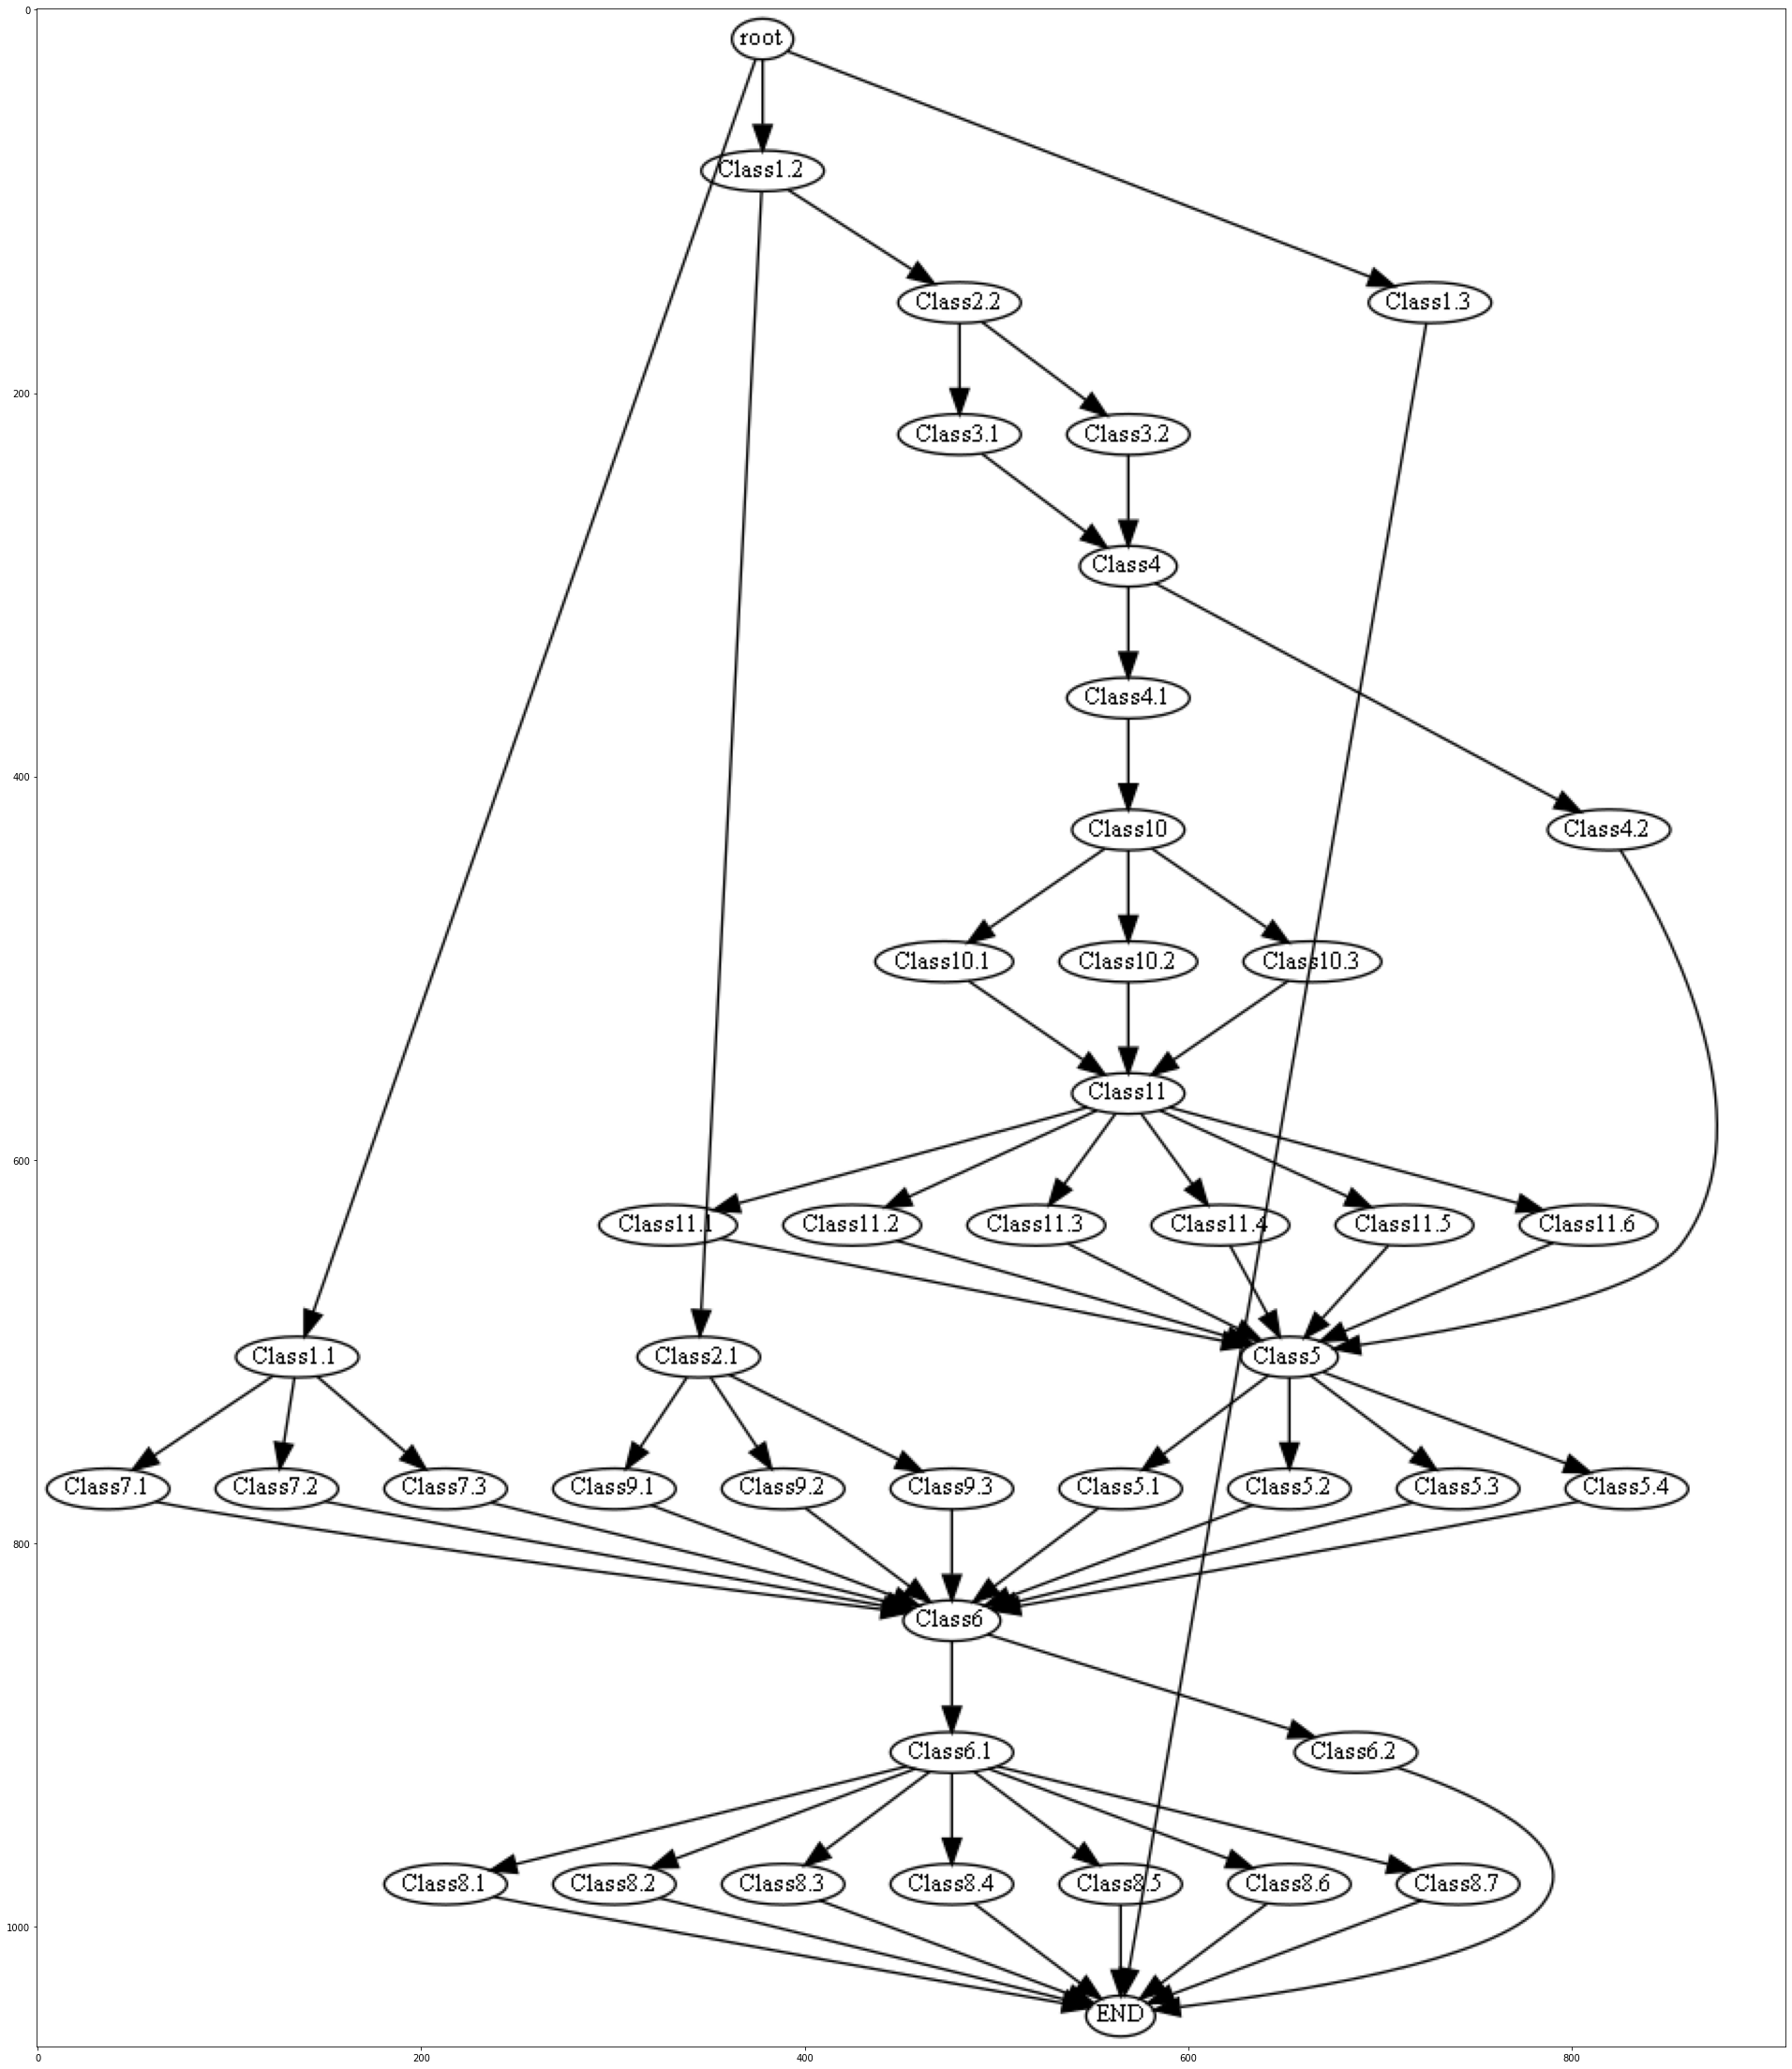

In [70]:
from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
from PIL import Image
g1 = nx.DiGraph()
g1.add_edges_from([("root", "Class1.1"), ("root", "Class1.2"), ("root", "Class1.3"), ("Class1.1", "Class7.1"),("Class1.1", "Class7.2"),("Class1.1", "Class7.3"),("Class1.2", "Class2.1"),("Class1.2", "Class2.2"),
                  ("Class2.1", "Class9.1"),("Class2.1", "Class9.2"),("Class2.1", "Class9.3"),("Class2.2", "Class3.1"),("Class2.2", "Class3.2"),("Class7.1", "Class6"),("Class7.2", "Class6"),("Class7.3", "Class6"),
                  ("Class6","Class6.1"),("Class6","Class6.2"),("Class6.1","Class8.1"),("Class6.1","Class8.2"),("Class6.1","Class8.3"),("Class6.1","Class8.4"),("Class6.1","Class8.5"),("Class6.1","Class8.6"),("Class6.1","Class8.7"),
                   ("Class6.2","END"),("Class8.1","END"),("Class8.2","END"),("Class8.3","END"),("Class8.4","END"),("Class8.5","END"),("Class8.6","END"),("Class8.7","END"),("Class1.3","END"),
                  ("Class9.1", "Class6"),("Class9.2", "Class6"),("Class9.3", "Class6"),("Class3.1", "Class4"),("Class4","Class4.1"),("Class4","Class4.2"),("Class3.1", "Class4"),("Class3.2", "Class4"),("Class4.1", "Class10"),("Class4.2", "Class5"),
                  ("Class10","Class10.1"),("Class10","Class10.2"),("Class10","Class10.3"),("Class10.1","Class11"),("Class10.2","Class11"),("Class10.3","Class11"),
                  ("Class11","Class11.1"),("Class11","Class11.2"),("Class11","Class11.3"),("Class11","Class11.4"),("Class11","Class11.5"),("Class11","Class11.6"),
                  ("Class11.1","Class5"),("Class11.2","Class5"),("Class11.3","Class5"),("Class11.4","Class5"),("Class11.5","Class5"),("Class11.6","Class5"),
                  ("Class5","Class5.1"),("Class5","Class5.2"),("Class5","Class5.3"),("Class5","Class5.4"),("Class5.1","Class6"),("Class5.2","Class6"),("Class5.3","Class6"),("Class5.4","Class6")])

# nx.nx_agraph.write_dot(g1,'test.dot')
# pos=graphviz_layout(g1, prog='dot')
# nx.draw(g1, pos, with_labels=False, arrows=False)
# plt.show()

A = nx.nx_agraph.to_agraph(g1)
A.layout('dot', args='-Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0 -Gfontsize=8')
A.draw('test.png')
img = Image.open('test.png')
plt.figure(figsize=(40,40))
plt.imshow(img)

In [71]:
edges = list(nx.edge_bfs(g1,"root"))
df1 = pd.DataFrame(edges)
df1.to_csv('tree.csv')

In [72]:
def search(className):
    cl = []
    for i,classes in enumerate(df1.iloc[:,0]):
        if(classes == className):
            cl.append(df1.iloc[i][1])
    return cl

In [73]:
search('Class7.2')

['Class6']

In [74]:
def find_max(row,classArr):
    max = -9999
    class_ans = ''
    for classes in classArr:
        if classes == 'Class6':
            return find_max(row,['Class6.1','Class6.2'])
        if classes == 'Class4':
            return find_max(row,['Class4.1','Class4.2'])
        if classes == 'Class10':
            return find_max(row,['Class10.1','Class10.2','Class10.3'])
        if classes == 'Class5':
            return find_max(row,['Class5.1','Class5.2','Class5.3','Class5.4'])
        if classes == 'Class11':
            return find_max(row,['Class11.1','Class11.2','Class11.3','Class11.4','Class11.5','Class11.6'])
        
        if df[classes][row] > max :
            max = df[classes][row]
            class_ans = classes
    return class_ans

In [75]:
find_max(0,search('Class6.1'))

'Class8.6'

In [76]:
df1.iloc[:,1]

0     Class1.1
1     Class1.2
2     Class1.3
3     Class7.1
4     Class7.2
        ...   
64      Class5
65      Class5
66      Class5
67      Class5
68      Class5
Name: 1, Length: 69, dtype: object

In [79]:
index = 0
values_per_cat = np.array(df.iloc[index,0:3])
maxarg = np.argmax(values_per_cat)
begin = df.columns[maxarg]

In [80]:
curr_class = begin
path_obtained = []
path_obtained.append(begin)
while(True):
    print("Searchin child of",curr_class)
    arr = search(curr_class)
    if(arr[0] == 'END'):
        print("The end")
        break
    
    max_class = find_max(index,arr)
    print("Max of ",curr_class,"is",max_class)
    print()
    curr_class = max_class
    path_obtained.append(curr_class)

Searchin child of Class1.2
Max of  Class1.2 is Class2.2

Searchin child of Class2.2
Max of  Class2.2 is Class3.2

Searchin child of Class3.2
Max of  Class3.2 is Class4.1

Searchin child of Class4.1
Max of  Class4.1 is Class10.2

Searchin child of Class10.2
Max of  Class10.2 is Class11.2

Searchin child of Class11.2
Max of  Class11.2 is Class5.2

Searchin child of Class5.2
Max of  Class5.2 is Class6.1

Searchin child of Class6.1
Max of  Class6.1 is Class8.6

Searchin child of Class8.6
The end


In [81]:
return_result(path_obtained)

The obtained classes are :  ['Class1.2', 'Class2.2', 'Class3.2', 'Class4.1', 'Class10.2', 'Class11.2', 'Class5.2', 'Class6.1', 'Class8.6']

It has features and disk
It is a disk viewed edge on
There is NO bar feature at the center of galaxy
There is a sign of spiral arm pattern
There is a just noticible Buldge in the center
There is something odd
It is a Merger Galaxy
It has medium tight spiral arms
There is 2 spiral arm
The END


In [82]:
print(answer[index])

Barred Spiral Galaxies


# Visualising How the model sees the Galaxy

In [83]:
import cv2         
import numpy as np    

image1 = cv2.imread('Final_inputs/2.jpg')
img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
ret, thresh1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY + 
                                            cv2.THRESH_OTSU) 
#cv2.imshow('Otsu Threshold', thresh1) 
filename = "test_image.jpg"
cv2.imwrite(filename,thresh1)
# De-allocate any associated memory usage         
if cv2.waitKey(0) & 0xff == 27:
    cv2.destroyAllWindows()  

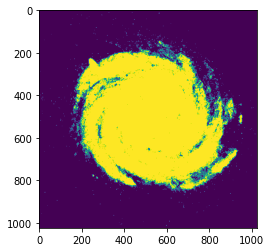

In [84]:
img = Image.open(filename)
plt.imshow(img)

# GPU Information

In [ ]:
!nvidia-smi